In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import welch
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

import hrvanalysis

In [11]:
filename = 'Checkme O2 Max _20250716192137'

In [44]:
df = pd.read_csv(f'Data/Watch/{filename}.csv')

# Remove non-numeric pulse entries if needed
df = df[df['Pulse Rate'] != '--']
df['Pulse Rate'] = pd.to_numeric(df['Pulse Rate'], errors='coerce')
df.dropna(subset=['Pulse Rate'], inplace=True)

# Convert Time column to datetime
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S %b %d %Y')

# Convert BPM to RR intervals in milliseconds
# RR(ms) = (60 / HR) * 1000
df['RR'] = 60 / df['Pulse Rate']

def compute_rmssd(rr_intervals):
    diffs = np.diff(rr_intervals)
    squared_diffs = diffs ** 2
    return np.sqrt(np.mean(squared_diffs))

# 10-point rolling RMSSD (adjust based on sampling rate)
df['RMSSD'] = df['RR'].rolling(window=10).apply(compute_rmssd, raw=True)

average_rmssd = df['RMSSD'].mean()
df['Above Avg HRV'] = df['RMSSD'] > average_rmssd


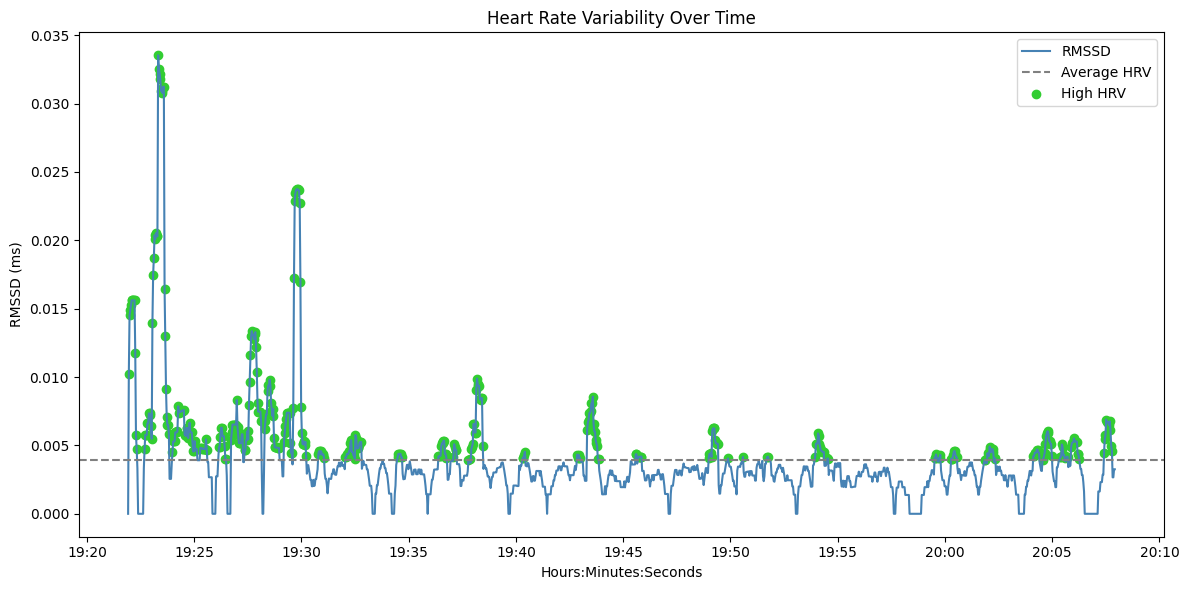

In [50]:

fig, ax = plt.subplots(figsize=(12,6))

# Example plot
ax.plot(df['Time'], df['RMSSD'], label='RMSSD', color='steelblue')
ax.axhline(average_rmssd, color='gray', linestyle='--', label='Average HRV')

# Format x-axis to show Hour:Minute:Second
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Highlight segments with above-average HRV
above_avg = df[df['Above Avg HRV']]
plt.scatter(above_avg['Time'], above_avg['RMSSD'], color='limegreen', label='High HRV')

plt.xlabel('Time')
plt.ylabel('RMSSD (ms)')
plt.title('Heart Rate Variability Over Time')
plt.xlabel('Hours:Minutes:Seconds')
plt.legend()
plt.tight_layout()
plt.show()

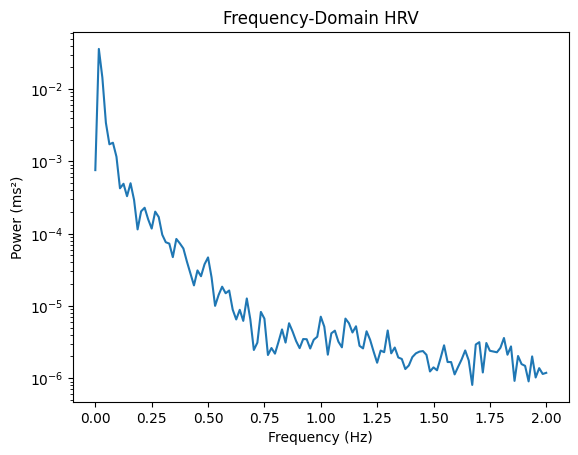

In [28]:
time_seconds = (df['Time'] - df['Time'].iloc[0]).dt.total_seconds()
interp_func = interp1d(time_seconds, df['RR'], kind='cubic')
new_time = np.linspace(time_seconds.min(), time_seconds.max(), len(df))
rr_interp = interp_func(new_time)

freqs, power = welch(rr_interp, fs=4.0)  # 4 Hz sampling rate

plt.semilogy(freqs, power)
plt.title('Frequency-Domain HRV')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (ms²)')
plt.show()

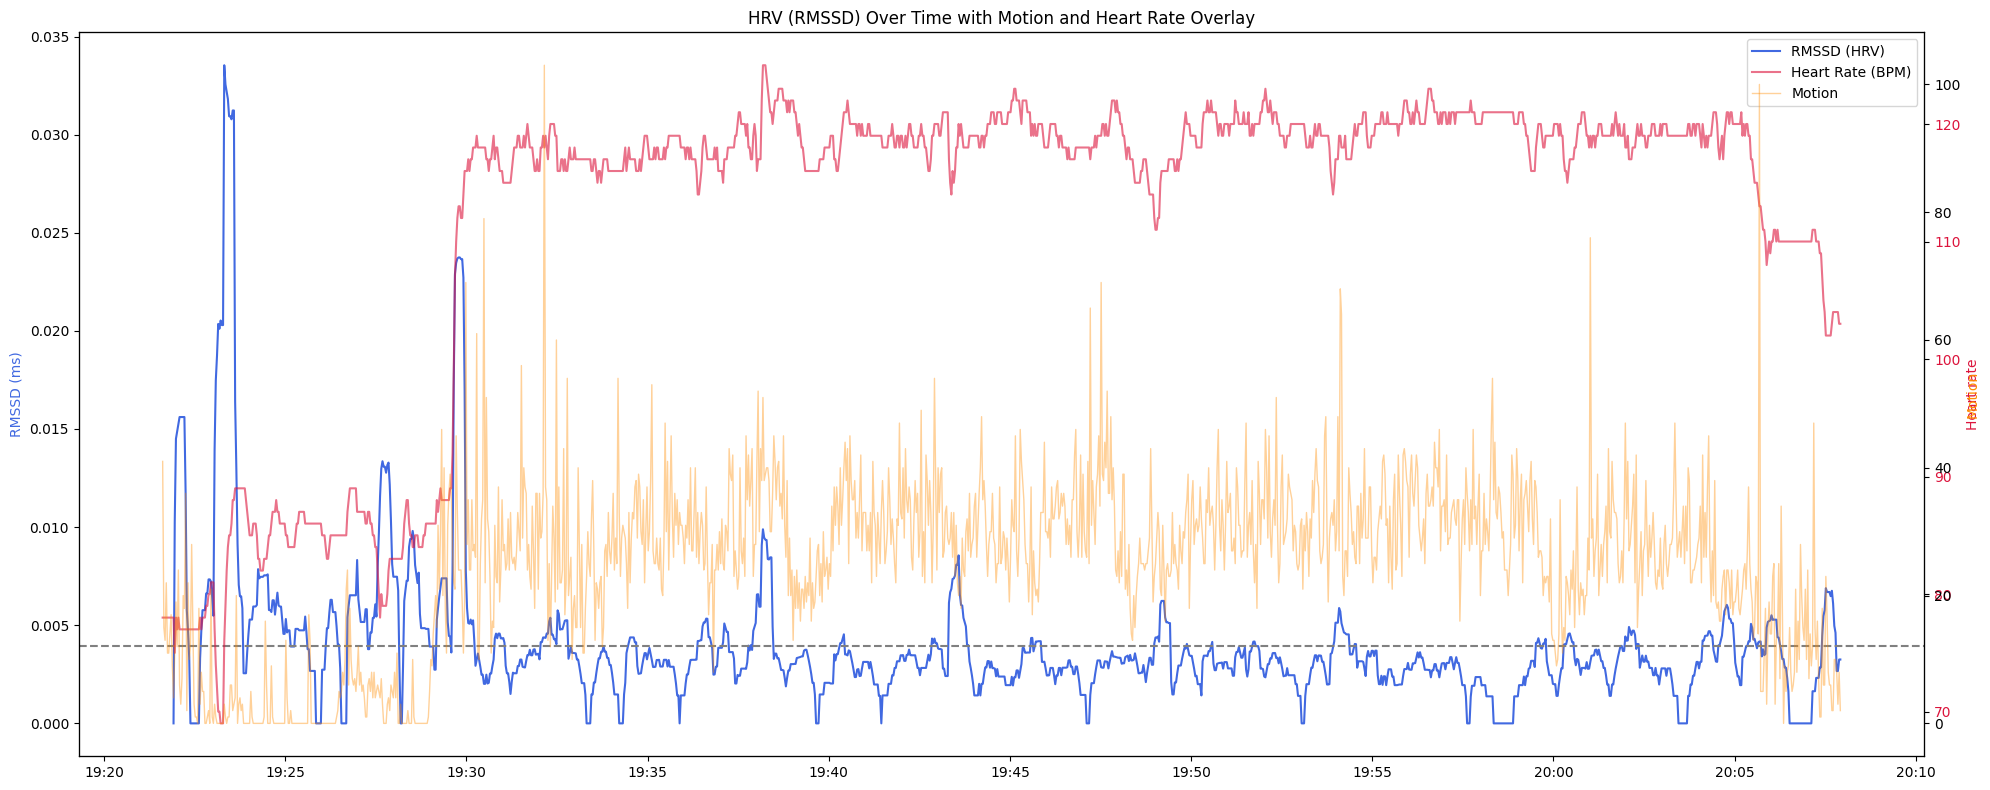

In [79]:
fig, ax1 = plt.subplots(figsize=(20,8))

# HRV Line
ax1.plot(df['Time'], df['RMSSD'], color='royalblue', label='RMSSD (HRV)')
ax1.set_ylabel('RMSSD (ms)', color='royalblue')
ax1.axhline(df['RMSSD'].mean(), color='gray', linestyle='--')

# Format x-axis to show Hour:Minute:Second
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Motion Line on right axis
ax2 = ax1.twinx()
ax2.plot(df['Time'], df['Pulse Rate'], color='crimson', label='Heart Rate (BPM)', alpha=0.6)
ax2.set_ylabel('Heart rate', color='crimson')
ax2.tick_params(axis='y', labelcolor='crimson')

ax3 = ax1.twinx()
ax3.plot(df['Time'], df['Motion'], color='darkorange', label='Motion', linestyle='-', linewidth=1, alpha=0.4)
ax3.set_ylabel('Motion', color='darkorange')

# Format x-axis to show Hour:Minute:Second
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Add legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
lines_3, labels_3 = ax3.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2 + lines_3, labels_1 + labels_2 + labels_3, loc='upper right')

plt.title('HRV (RMSSD) Over Time with Motion and Heart Rate Overlay')
plt.tight_layout()
plt.show()

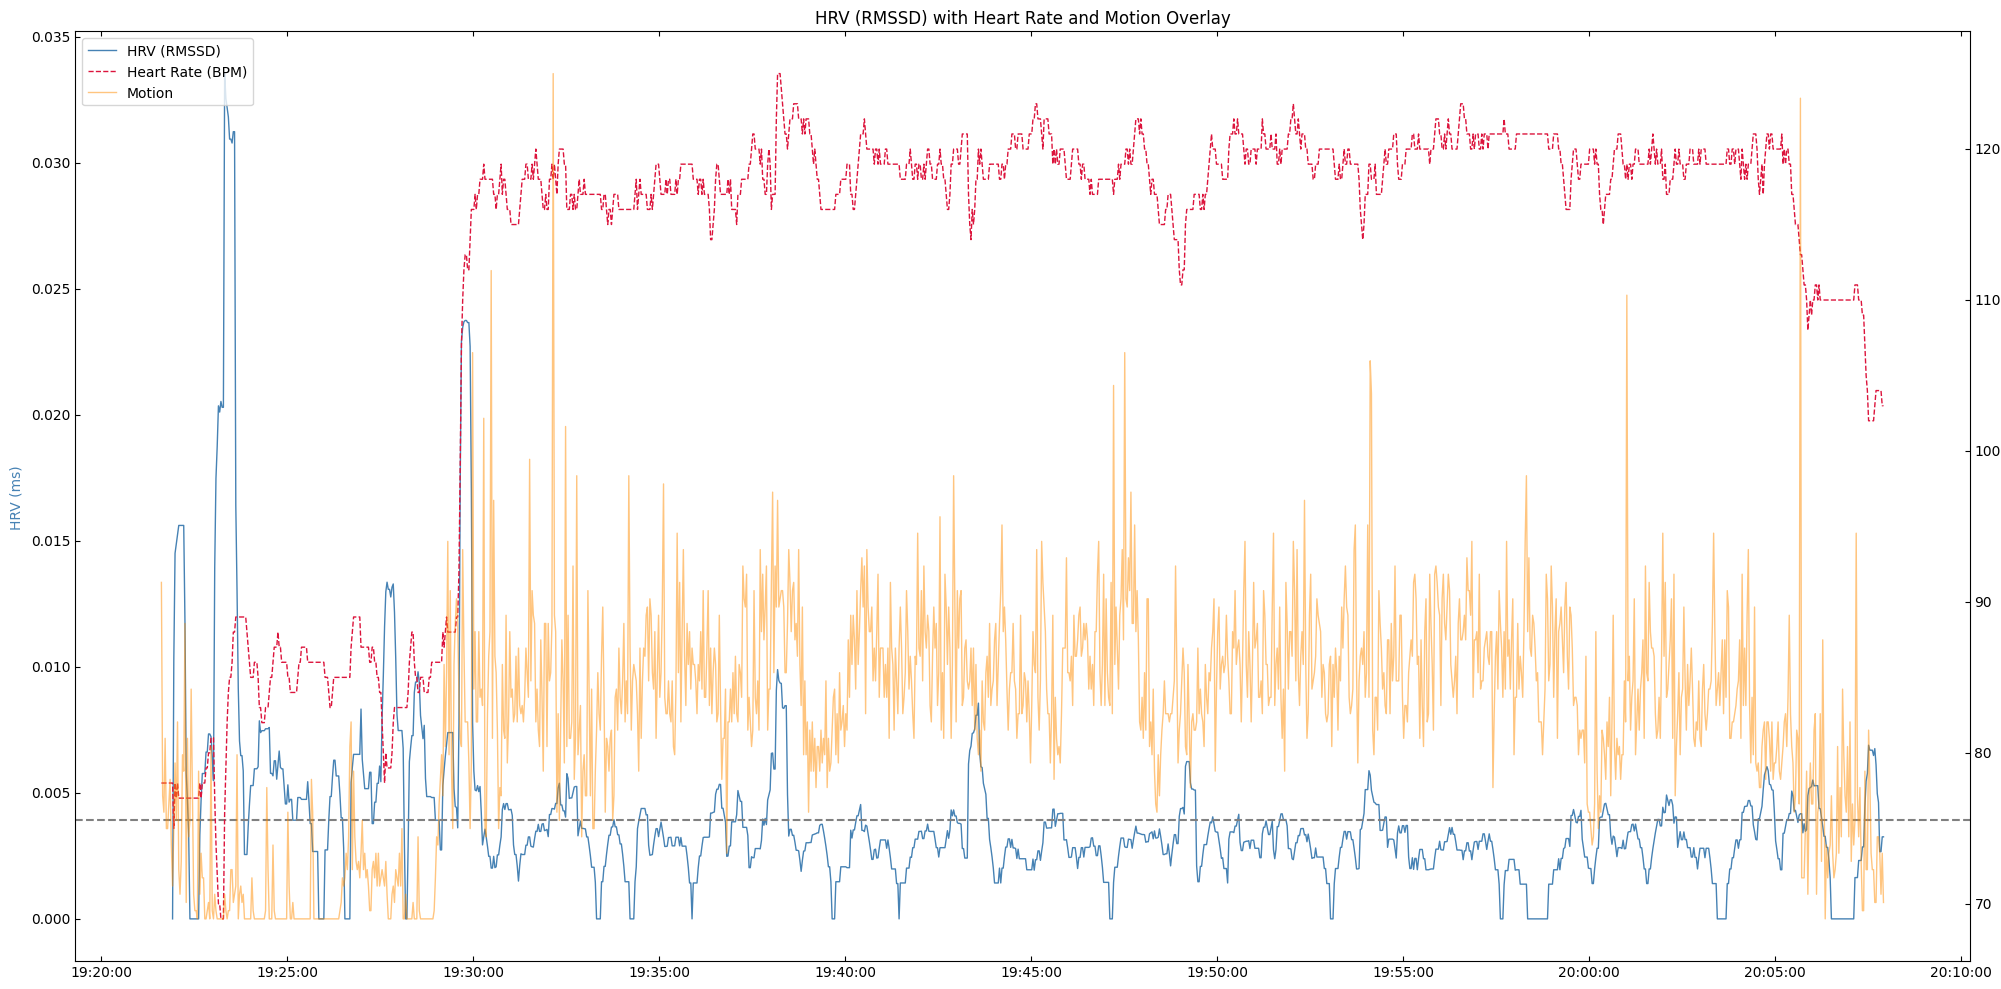

In [84]:
# Create triple y-axis layout
fig = plt.figure(figsize=(20,10))
host = host_subplot(111, axes_class=AA.Axes)
plt.subplots_adjust(right=0.75)

par1 = host.twinx()      # Right axis for Heart Rate
par2 = host.twinx()      # Motion layer

# 📌 Offset heart rate axis further to the right
par1.axis["right"].toggle(all=True)
par2.axis["right"] = par2.get_grid_helper().new_fixed_axis(loc="right", axes=par2, offset=(60, 0))
par2.axis["right"].toggle(all=True)

# ⏰ Format x-axis ticks
host.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

# 🟦 Plot RMSSD on left y-axis
p1, = host.plot(df['Time'], df['RMSSD'], color='steelblue', label='HRV (RMSSD)', linewidth=1)
host.axhline(df['RMSSD'].mean(), color='gray', linestyle='--')
host.set_ylabel('HRV (ms)', color='steelblue')
host.tick_params(axis='y', labelcolor='steelblue')

# 🔴 Heart Rate on second y-axis
p2, = par1.plot(df['Time'], df['Pulse Rate'], color='crimson', linestyle='--', label='Heart Rate (BPM)', linewidth=1)
par1.set_ylabel('Heart Rate (BPM)', color='crimson')
par1.tick_params(axis='y', labelcolor='crimson')

# 🟧 Motion as third line without visible axis
p3, = par2.plot(df['Time'], df['Motion'], color='darkorange', label='Motion', alpha=0.5, linewidth=1)
par2.axis["right"].label.set_visible(False)
par2.axis["right"].major_ticklabels.set_visible(False)
par2.axis["right"].major_ticks.set_visible(False)

# 🧭 Legend
host.legend(handles=[p1, p2, p3], loc='upper left')
plt.title('HRV (RMSSD) with Heart Rate and Motion Overlay')
plt.tight_layout()
plt.show()